In [1]:
# Import PyTorch
import torch
import torch.nn as nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
input_channels = 3
num_classes = 10

---
# Getting data

In [4]:
# !cp -r /content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data /content/local_dataset-floodnet

In [5]:
# data_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data'
# train_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data/train'

# train_image_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data/train/train-org-img'
# train_mask_folder = r'/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data/train/train-label-img'

In [6]:
data_folder = r'/mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset'
train_folder = r'/mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train'

train_image_folder = r"/mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train/train-org-img"
train_mask_folder = r'/mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train/train-label-img'

In [7]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} files/images in {dirpath}")

In [8]:
walk_through_dir(data_folder)

There are 3 directories and 1 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset
There are 2 directories and 0 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/test
There are 0 directories and 448 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/test/test-label-img
There are 0 directories and 448 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/test/test-org-img
There are 2 directories and 0 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train
There are 0 directories and 1445 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train/train-label-img
There are 0 directories and 1445 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train/train-org-img
There are 2 directories and 0 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/val
There are 0 directories and 450 files/images in /mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/va

In [9]:
# prompt: Write code for a function that will plot a random image from the folder given

import torchvision.io as tv
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import os
import random

def plot_random_image(img_folder, label_folder):
  """
  This function plots a random image from the given folder.

  Args:
    folder: The folder path containing the images.
  """
  print(img_folder)

  # Get a list of all files in the folder
  files = os.listdir(img_folder)

  # Choose a random image from the list
  random_image_index = random.randint(0, len(files) - 1)
  random_image_name = files[random_image_index][:-4]
  random_image_path = os.path.join(img_folder, random_image_name + '.jpg')

  random_label_path = os.path.join(label_folder, random_image_name + '_lab.png')

  # Load the image using matplotlib
  img = plt.imread(random_image_path)
  label = plt.imread(random_label_path)

  # OR
  # Load the image using pytorch
  # img = tv.read_image(random_image_path)
  # label = tv.read_image(random_label_path)
  # img = img.permute(1, 2, 0)
  # label = label.permute(1, 2, 0)

  # Display the image
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  plt.imshow(label)
  plt.axis('off')
  plt.show()

/mnt/c/Users/Jezza/Desktop/Datasets/FloodNet-Dataset/train/train-org-img


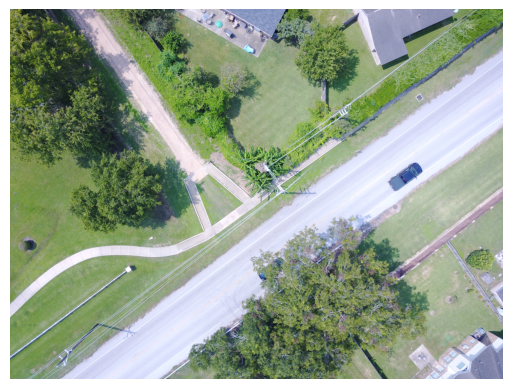

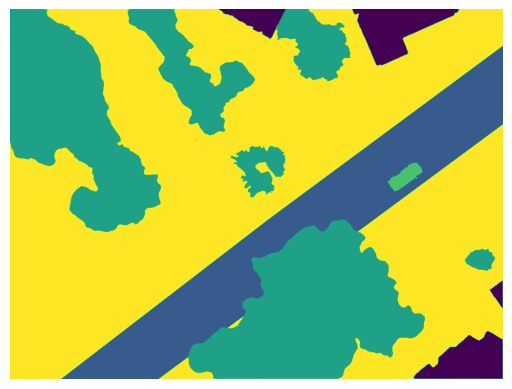

In [10]:
plot_random_image(train_image_folder, train_mask_folder)

---
# Creating data loaders

In [11]:
from torchvision.transforms import v2
import torchvision.transforms as T

data_transformer = v2.Compose([
    T.Resize((128, 128)),
    # v2.RandomHorizontalFlip(p=0.5),
    # v2.RandomRotation(30),
    v2.ToTensor()
])

/home/jeremy_h/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [12]:
from torch.utils.data.dataset import Dataset
from PIL import Image

class floodDataset(Dataset):
  def __init__(self, img_path, mask_path, transform = None):
    self.image_paths = sorted([os.path.join(img_path, path) for path in os.listdir(img_path)])
    self.mask_paths = sorted([os.path.join(mask_path, path) for path in os.listdir(mask_path)])

    self.transform = transform

  def load_image_pair(self, index):
    image = self.image_paths[index]
    mask = self.mask_paths[index]
    return Image.open(image), Image.open(mask)

  def __getitem__(self, index):
    img, mask = self.load_image_pair(index)

    if self.transform:
      img = self.transform(img)
      mask = self.transform(mask)
      mask = torch.max(mask, dim=0)[0]
      mask *= 255
      return img, mask.long()

  def __len__(self):
    return len(self.image_paths)

In [13]:
train_dataset = floodDataset(train_image_folder, train_mask_folder, data_transformer)

In [14]:
print(len(train_dataset))

1445


In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_dataset,  # Custom created train Dataset
                              batch_size=8,          # Experiment with increasing this if GPU memory allows
                              num_workers=20,          # 8 workers to balance CPU usage and loading speed
                              pin_memory=True,        # Enable pinned memory for faster data transfer to GPU
                              prefetch_factor=4,      # Prefetch 2 batches per worker to optimize data loading
                              persistent_workers=True, # Keep workers alive between epochs for efficiency
                              shuffle=True)           # Shuffle the training data

# test_dataloader_custom = DataLoader(dataset=test_dataset, # use custom created test Dataset
#                                     batch_size=1,
#                                     num_workers=0,
#                                     shuffle=False) # don't usually need to shuffle testing data

train_dataloader

In [16]:
for img_batch, mask_batch in train_dataloader:
  img = img_batch[0,:,:,:]
  mask = mask_batch[0,:,:]

  print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
  print(f"Mask shape: {mask.shape} -> [batch_size, color_channels, height, width]")

  print(mask)

  break

Image shape: torch.Size([3, 128, 128]) -> [batch_size, color_channels, height, width]
Mask shape: torch.Size([128, 128]) -> [batch_size, color_channels, height, width]
tensor([[9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        ...,
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9],
        [9, 9, 9,  ..., 9, 9, 9]])


---
# Class weights

In [17]:
import os
import numpy as np
import torch
from collections import Counter

def compute_class_weights(dataset, num_classes, file_path="class_weights.pth"):
    # Check if the file already exists
    if os.path.exists(file_path):
        print(f"Loading class weights from {file_path}")
        class_weights = torch.load(file_path)
        print(class_weights)
    else:
        print(f"Computing class weights and saving to {file_path}")
        # Initialize a counter for each class
        class_counts = Counter()

        # Iterate through the dataset and count each class
        for _, mask in dataset:
            class_counts.update(mask.flatten().tolist())

        # Create a numpy array of class counts
        class_counts = np.array([class_counts[i] for i in range(num_classes)])

        # Compute weights as the inverse of class frequency
        class_weights = 1. / class_counts
        class_weights /= class_weights.sum()  # Normalize to sum to 1

        # Convert to a PyTorch tensor and save to a file
        class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
        torch.save(class_weights, file_path)
        
    return class_weights

num_classes = 10  # Number of classes in your dataset
class_weights = compute_class_weights(train_dataset, num_classes, file_path="class_weights.pth")


Loading class weights from class_weights.pth
tensor([0.1629, 0.1933, 0.0852, 0.0931, 0.0496, 0.0233, 0.0155, 0.1998, 0.1724,
        0.0049], device='cuda:0')


/tmp/ipykernel_1480543/1080314800.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(file_path)


---
# Create UNet

In [18]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

  def forward(self, x):
    return self.double_conv(x)

In [19]:
class Down(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.double_conv = DoubleConv(in_channels, out_channels)
    self.down = nn.MaxPool2d(2)

  def forward(self, x):
    skip_con = self.double_conv(x)
    down = self.down(skip_con)
    return (down, skip_con)

In [20]:
class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
    self.double_conv = DoubleConv(in_channels, out_channels)

  def forward(self, x, skip_con):
    x = self.up(x)
    x = torch.cat([x, skip_con], dim=1)
    x = self.double_conv(x)
    return x

In [21]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.down1 = Down(in_channels, 64)
    self.down2 = Down(64, 128)
    self.down3 = Down(128, 256)
    self.down4 = Down(256, 512)

    self.bottleneck = DoubleConv(512, 1024)

    self.up1 = Up(1024, 512)
    self.up2 = Up(512, 256)
    self.up3 = Up(256, 128)
    self.up4 = Up(128, 64)

    self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

  def forward(self, x):
    down_1, skip_con1 = self.down1(x)
    down_2, skip_con2 = self.down2(down_1)
    down_3, skip_con3 = self.down3(down_2)
    down_4, skip_con4 = self.down4(down_3)

    b = self.bottleneck(down_4)

    up_1 = self.up1(b, skip_con4)
    up_2 = self.up2(up_1, skip_con3)
    up_3 = self.up3(up_2, skip_con2)
    up_4 = self.up4(up_3, skip_con1)

    out = self.out(up_4)

    return out

---
# Dummy run UNET and get summary

In [22]:
model = UNet(input_channels, num_classes).to(device)

In [23]:
img_batch, mask_batch = next(iter(train_dataloader))

img_single, mask_single = img_batch[0].unsqueeze(dim=0).to(device), mask_batch[0].unsqueeze(dim=0).to(device)
print(f"Single image shape: {img_single.shape}\n")
print(f"Single mask shape: {mask_single.shape}\n")

Single image shape: torch.Size([1, 3, 128, 128])

Single mask shape: torch.Size([1, 128, 128])



In [24]:
output = model(img_single)
print(output)

tensor([[[[-0.0684, -0.0723, -0.0736,  ..., -0.0720, -0.0734, -0.0707],
          [-0.0681, -0.0713, -0.0728,  ..., -0.0712, -0.0727, -0.0695],
          [-0.0693, -0.0718, -0.0723,  ..., -0.0716, -0.0715, -0.0692],
          ...,
          [-0.0692, -0.0719, -0.0741,  ..., -0.0715, -0.0699, -0.0682],
          [-0.0686, -0.0693, -0.0706,  ..., -0.0686, -0.0682, -0.0673],
          [-0.0700, -0.0698, -0.0703,  ..., -0.0699, -0.0687, -0.0675]],

         [[-0.0050, -0.0004, -0.0031,  ..., -0.0022, -0.0028, -0.0042],
          [-0.0080, -0.0066, -0.0075,  ..., -0.0059, -0.0062, -0.0055],
          [-0.0045, -0.0043, -0.0053,  ..., -0.0018, -0.0038, -0.0038],
          ...,
          [-0.0053, -0.0041, -0.0053,  ..., -0.0032, -0.0053, -0.0040],
          [-0.0064, -0.0052, -0.0050,  ..., -0.0025, -0.0045, -0.0044],
          [-0.0068, -0.0071, -0.0053,  ..., -0.0043, -0.0070, -0.0047]],

         [[-0.0232, -0.0269, -0.0259,  ..., -0.0243, -0.0247, -0.0235],
          [-0.0239, -0.0263, -

In [25]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1,3,128,128])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 10, 128, 128]         --
├─Down: 1-1                              [1, 64, 64, 64]           --
│    └─DoubleConv: 2-1                   [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1              [1, 64, 128, 128]         38,720
│    └─MaxPool2d: 2-2                    [1, 64, 64, 64]           --
├─Down: 1-2                              [1, 128, 32, 32]          --
│    └─DoubleConv: 2-3                   [1, 128, 64, 64]          --
│    │    └─Sequential: 3-2              [1, 128, 64, 64]          221,440
│    └─MaxPool2d: 2-4                    [1, 128, 32, 32]          --
├─Down: 1-3                              [1, 256, 16, 16]          --
│    └─DoubleConv: 2-5                   [1, 256, 32, 32]          --
│    │    └─Sequential: 3-3              [1, 256, 32, 32]          885,248
│    └─MaxPool2d: 2-6                    [1, 256, 16, 16]          --
├

---
# Train UNet

In [26]:
def dice_loss(pred, target, smooth=1e-6):
    # Apply softmax to get class probabilities
    pred = torch.softmax(pred, dim=1)

    # Convert target to one-hot encoding
    target_one_hot = torch.zeros_like(pred)
    target_one_hot.scatter_(1, target.unsqueeze(1), 1)

    # Flatten the predictions and target for each class
    pred_flat = pred.contiguous().view(-1)
    target_flat = target_one_hot.contiguous().view(-1)
    
    # Calculate intersection and union
    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

    return 1 - dice  # Dice loss is 1 - Dice coefficient

In [27]:
from tqdm.auto import tqdm
from torch.nn import functional as F

def train_step(model, dataloader, loss_fn, optimizer):
  # Put model in training mode
  model.train()

  # Initiate train loss/accuracy
  train_loss, correct_pixels, total_pixels = 0, 0, 0

  for n_batch, img_mask in enumerate(tqdm(dataloader)):

    img = img_mask[0].to(device)
    mask = img_mask[1].to(device)

    # Forward pass
    mask_pred = model(img)

    # Calculate and accumulate loss
    loss = loss_fn(mask_pred, mask)
    train_loss += loss.item()

    # Reset optimizer to zero gradient
    optimizer.zero_grad()

    # Back prop
    loss.backward()

    # Optimizer step (change params)
    optimizer.step()

    mask_pred_prob = F.softmax(mask_pred, dim=1)
    _, predicted = torch.max(mask_pred_prob, 1)

    correct_pixels += (predicted == mask).sum().item()
    total_pixels += mask.numel()

  train_loss = train_loss / len(dataloader)
  train_acc = correct_pixels / total_pixels

  return train_loss, train_acc

/home/jeremy_h/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
from timeit import default_timer as timer

def train(model, dataloader, loss_fn, optimizer, epochs=5):
  start_time = timer()

  results = {"train_loss": [],
             "train_acc": []}

  for epoch in range(epochs):
    train_loss, train_acc = train_step(model, dataloader, loss_fn, optimizer)

    print(
        f"Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f}"
    )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)

  end_time = timer()

  print(f"Total training time: {(end_time - start_time):.3f} seconds")
  return results

In [29]:
model_1 = UNet(input_channels, num_classes).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

train(model_1, train_dataloader, loss_fn, optimizer, epochs=100)

  0%|          | 0/181 [00:19<?, ?it/s]


KeyboardInterrupt: 

In [22]:
for img_batch, mask_batch in train_dataloader:
  img = img_batch[0,:,:,:]
  mask = mask_batch[0,:,:]

  print(img)

  mask_pred = model_1(img.unsqueeze(dim=0).to(device))
  mask_pred_prob = F.softmax(mask_pred, dim=1)
  _, predicted = torch.max(mask_pred_prob, 1)
  predicted = predicted.squeeze().cpu().numpy()

  print(predicted.shape)
  print(mask.shape)
  print(img.shape)

  plt.imshow(img.permute(1, 2, 0))
  plt.axis('off')
  plt.show()

  plt.imshow(mask)
  plt.axis('off')
  plt.show()

  plt.imshow(predicted)
  plt.axis('off')
  plt.show()

  break

tensor([[[115, 114,  94,  ...,  78,  81,  81],
         [114, 118, 103,  ...,  81,  85,  86],
         [141, 126, 112,  ...,  98,  88,  86],
         ...,
         [ 82,  89,  80,  ..., 116, 111, 118],
         [ 73,  81,  83,  ..., 113, 119, 112],
         [ 79,  93,  77,  ..., 112, 133, 114]],

        [[144, 138, 116,  ..., 109, 109, 104],
         [144, 140, 123,  ..., 110, 110, 108],
         [152, 136, 129,  ..., 121, 114, 110],
         ...,
         [108, 117, 105,  ..., 126, 126, 132],
         [ 99, 109, 113,  ..., 124, 130, 125],
         [107, 123, 108,  ..., 125, 139, 129]],

        [[ 78,  91,  91,  ...,  42,  51,  52],
         [ 81,  97, 101,  ...,  45,  50,  54],
         [136, 127, 113,  ...,  70,  54,  53],
         ...,
         [ 96,  86,  85,  ...,  81,  78,  91],
         [ 85,  82,  83,  ...,  71,  88,  79],
         [ 80,  81,  77,  ...,  75, 110,  84]]], dtype=torch.uint8)


NameError: name 'model_1' is not defined

In [61]:
model_save_path = 'my_model.pth'  # Path where you want to save your model

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to my_model.pth


In [62]:
# import os
# import shutil

# # Path to the shared folder (add the shared folder to your drive first)
# shared_drive_path = '/content/gdrive/MyDrive/FloodNet-Supervised_v1.0'

# # Path to your own Google Drive
# my_drive_path = '/content/gdrive/MyDrive/Colab_Notebooks/FloodNet/FloodNet_Data'

# # Create the destination directory if it doesn't exist
# os.makedirs(my_drive_path, exist_ok=True)

# # Function to copy files and directories
# def copy_files_and_directories(src, dst):
#     if os.path.isdir(src):
#         # If the item is a directory, copy it recursively
#         shutil.copytree(src, dst, dirs_exist_ok=True)
#         print(f"Directory copied: {src} to {dst}")
#     else:
#         # If the item is a file, copy it
#         shutil.copy(src, dst)
#         print(f"File copied: {src} to {dst}")

# # Copy files and directories from shared drive to your own drive
# for item in os.listdir(shared_drive_path):
#     src_path = os.path.join(shared_drive_path, item)
#     dst_path = os.path.join(my_drive_path, item)

#     # Call the function to copy files and directories
#     copy_files_and_directories(src_path, dst_path)

# print("Files and directories copied successfully.")